In [1]:
import os
import sys
sys.path.append("..")
os.environ["PATH"] = os.environ["PATH"] + ":/clusterfs/nilah/pooja/software/bin"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import h5py

import coolbox
from coolbox.api import *

from utils.plot import *

In [2]:
fig_dir = "/clusterfs/nilah/pooja/CellTypeSpecificAccessibilityPrediction/figures/fig3"

### 3A -- Heritability in cell-type specific and ubiquitous peaks

In [3]:
def read_ldsc_results(results_dir, traits, peak_labels):
    ldsc_results = {}
    for trait_label, trait in traits.items():
        ldsc_results[trait_label] = []
        for peak_label, peak_annot in peak_labels.items():
            tmp_df= pd.read_csv(f"{results_dir}/{trait}_baseline_remove_enhancer_promoter_annots_{peak_annot}.results", 
                                              sep="\t", header=0, index_col=0)

            ldsc_results[trait_label].append(tmp_df[-1:])
        ldsc_results[trait_label] = pd.concat(ldsc_results[trait_label], axis=0)
        ldsc_results[trait_label].index = peak_labels.keys()
        
    return ldsc_results

Loeb et al.

In [4]:
results_dir = "/clusterfs/nilah/pooja/kidney_data/ldsc/partitioned_heritability"
traits = {"Creatinine": "kidney_30700_UKBB"}
peak_labels =  {"PT": "cluster11_PT_baseline_snp_list",
               "DT/LOH": "cluster4_DistalNephron_baseline_snp_list",
               "Str": "cluster9_Stroma_baseline_snp_list",
               "Ubiquitous": "cluster3_Ubiquitous"}
ldsc_results = read_ldsc_results(results_dir, traits, peak_labels)

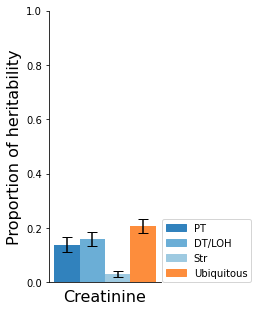

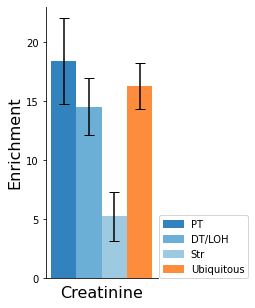

In [51]:
cmap = plt.get_cmap("tab20c")
colors = [cmap(0), cmap(1), cmap(2), cmap(5)]
plot_cols = ["Prop._h2", "Enrichment"]

for plot_col in plot_cols:
    for i, trait_label in enumerate(traits.keys()):
        fig, ax = plt.subplots(1, 1, figsize=(2, 5))
        ax.bar(np.arange(ldsc_results[trait_label].shape[0]),
               ldsc_results[trait_label][plot_col] , 
               yerr=ldsc_results[trait_label][f"{plot_col}_std_error"],
               capsize=5, width=1, color=colors)

        ax.set_xlabel(trait_label, fontsize=16)
        ax.set_xticks([])
        if plot_col == "Prop._h2":
            ax.set_ylabel("Proportion of heritability", fontsize=16)
            ax.set_ylim(0, 1)
        else:
            ax.set_ylabel(plot_col, fontsize=16)
            ax.set_ylim(0, 23)
        sns.despine()
        
        patches = []
        for i, cell_type in enumerate(ldsc_results[trait_label].index.values):
            patches.append(mpatches.Patch(color=colors[i], label=cell_type))
        plt.legend(handles=patches, loc=(1.01,0))
        plt.tight_layout()
        plt.savefig(f"{fig_dir}/loeb_et_al_{trait_label}_{plot_col}_per_cluster.pdf", 
                        dpi=300)


Calderon et al.

In [7]:
traits = {"Crohn's\nDisease": "PASS_Crohns_Disease", 
          "Rheumatoid\nArthritis": "PASS_Rheumatoid_Arthritis", 
          "Ulcerative\nColitis": "PASS_Ulcerative_Colitis"}
results_dir = "/clusterfs/nilah/pooja/immune_atlas/ldsc/partitioned_heritability"
peak_labels = { "DCmye": "cluster_myeloid_resting_baseline_snp_list",
               "NKim": "cluster_nk_resting_baseline_snp_list",
               "TCD8EM": "cluster_T_resting_baseline_snp_list",
               "Ubiquitous": "cluster_open"}
ldsc_results = read_ldsc_results(results_dir, traits, peak_labels)

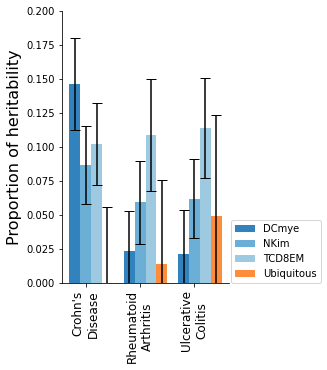

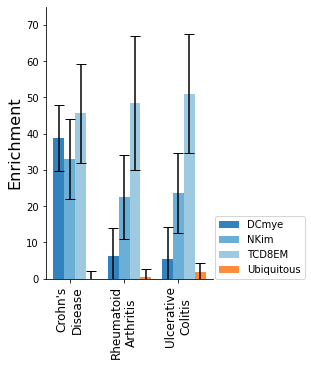

In [61]:
cmap = plt.get_cmap("tab20c")
colors = [cmap(0), cmap(1), cmap(2), cmap(5)]
width = 0.2
plot_cols = ["Prop._h2", "Enrichment"]

for plot_col in plot_cols:
    fig, ax = plt.subplots(figsize=(3, 5))

    for i, peak_cluster in enumerate(peak_labels):
        prop_h2 = np.array([ldsc_results[trait].loc[peak_cluster, plot_col] 
                            for trait in traits.keys()])
        prop_h2_se = np.array([ldsc_results[trait].loc[peak_cluster, f"{plot_col}_std_error"] 
                               for trait in traits.keys()])

        plt.bar(np.arange(len(traits))+i*width,
                prop_h2,
                width, yerr=prop_h2_se, 
                capsize=5, label=peak_cluster, color=colors[i])

    plt.xticks(ticks=np.arange(len(traits))+width, 
               labels=traits.keys(),
               fontsize=12, rotation=90)
    
    if plot_col == "Prop._h2":
        plt.ylabel("Proportion of heritability", fontsize=16)
        plt.ylim(0, 0.2)
    else:
        plt.ylabel(plot_col, fontsize=16)
        plt.ylim(0, 75)
    
    plt.legend(fontsize=10, loc=(1.01, 0))
    sns.despine()
    plt.savefig(f"{fig_dir}/calderon_et_al_{plot_col}_per_cluster.pdf", dpi=300)


### 3B -- Loop of Henle scatter plot in cell-type specific and ubiquitous peaks

Read in data

In [3]:
data_dir = "/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11/model_predictions"
model_dir = "/clusterfs/nilah/pooja/kidney_data/train/replicate_models/train__multitask__all_sequences__1"
clusters = ["cluster4_DistalNephron", "cluster3_Ubiquitous", "all_sequences"]
targets = pd.read_csv("/clusterfs/nilah/pooja/kidney_data/targets.txt", sep="\t", header=0, index_col=0)
cell_types = targets["identifier"].values

preds_dict = {}
for cluster in clusters:
    preds = h5py.File(f"{model_dir}/predict_beds/{cluster}/predict.h5", "r")
    preds_df = pd.DataFrame(np.nan_to_num(np.squeeze(preds["preds"][:,:,:])), 
                            columns=[f"{ct}_pred" for ct in cell_types])  
    preds_df["chrom"] = preds["chrom"][:].astype(str)
    preds_df["start"] = preds["start"][:]
    preds_df["end"] = preds["end"][:]
    
    predict_regions = pd.read_csv(f"{data_dir}/{cluster}/predict_regions.bed", 
                                  sep="\t", names=["chrom", "start", "end", "name"])
    preds_df = preds_df.merge(predict_regions, on=["chrom", "start", "end"], how="inner")

    for cell_type in cell_types:
        cell_type_targets = pd.read_csv(f"{data_dir}/{cluster}/{cell_type}_target_signal.out", 
                                        sep="\t", index_col=0, 
                                        names=["size", "covered", "sum", "mean0", "mean"])
        cell_type_targets = cell_type_targets.loc[preds_df["name"].values]["sum"].values
        preds_df[f"{cell_type}_target"] = cell_type_targets
        
    preds_dict[cluster] = preds_df

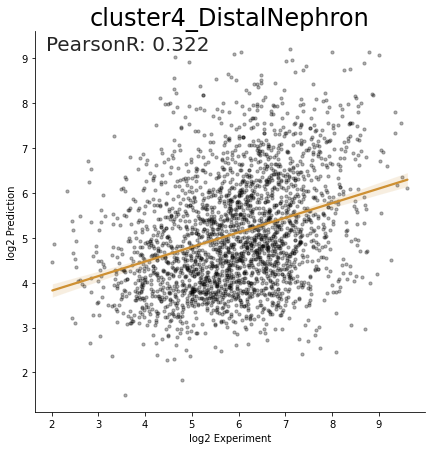

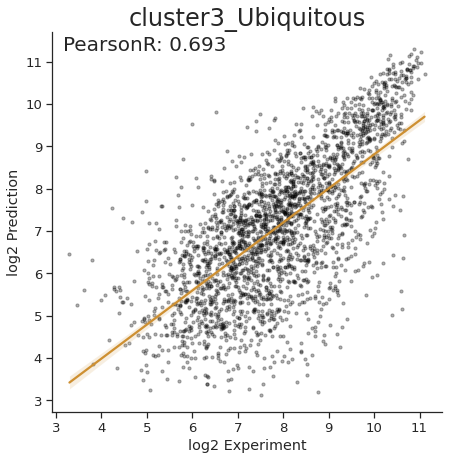

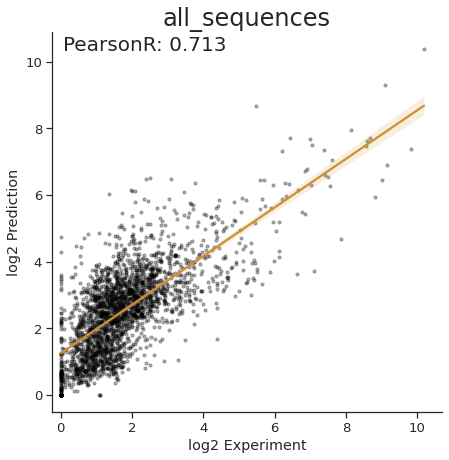

In [4]:
sample_size = 2500
cell_type = "LOH"
for cluster in clusters:
    sample_inds = np.random.choice(len(preds_dict[cluster]), sample_size, replace=False)
    # subset and flatten
    test_targets_ti_flat = preds_dict[cluster][f"{cell_type}_target"].values[sample_inds].flatten(
      ).astype('float32')
    test_preds_ti_flat = preds_dict[cluster][f"{cell_type}_pred"].values[sample_inds].flatten().astype(
          'float32')

    # take log2
    test_targets_ti_log = np.log2(test_targets_ti_flat + 1)
    test_preds_ti_log = np.log2(test_preds_ti_flat + 1)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    scatter_plot(test_targets_ti_log, test_preds_ti_log, cluster, ax, alpha=0.3)
    sns.despine()
    plt.savefig(f"{fig_dir}/{cell_type}_{cluster}_scatter_plot_small.pdf", dpi=150)

### 3C -- Model performance in cell-type specific and ubiquitous peaks

See `{dataset}_model_performance_evals.ipynb`

### 3D -- Loeb et al. measured and predicted accessibility tracks

1. Create bed file with prediction windows

In [ ]:
## NR2F1 -- chr5:93,537,337-93,616,354

bed_ranges = []
chr = "chr5"
start_ = 93500000
start = start_
end = 93650000

while start < end:
    bed_ranges.append((chr, start, start+192))
    start = start+193
pd.DataFrame(bed_ranges).to_csv(f"/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11/plot_track_{chr}_{start_}_{end}.bed", sep="\t", header=False, index=False)

2. Make predictions for regions in bed file

In [ ]:
%%bash

## run this from a batch script on savio3_gpu
## NR2F1 -- chr5:93,537,337-93,616,354

chr="chr5"
start="93500000"
end="93650000"

model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"
regions_bed="/clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11/plot_track_${chr}_${start}_${end}.bed"

# multitask
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 0,1,2,3,4,5,6,7,8,9 -f /clusterfs/nilah/pooja/genomes/hg38.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg38.genome"
model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/kidney_data/targets.txt"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask.json"
${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}

# high-capacity multitask
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 0,1,2,3,4,5,6,7,8,9 -f /clusterfs/nilah/pooja/genomes/hg38.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg38.genome"
model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/kidney_data/targets.txt"
params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_multitask_8x_params_same_layers.json"
${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}

# single task
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 0 -f /clusterfs/nilah/pooja/genomes/hg38.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg38.genome"
for cell_type in PT LOH DT Str;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/kidney_data/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/kidney_data/models/params_sc_kidney_regression_single_task.json"
    ${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}
done


3. Combine prediction bigwigs into one file

In [3]:
%%bash

chr="chr5"
start="93500000"
end="93650000"

num_files=$(wc -l < /clusterfs/nilah/pooja/kidney_data/CellTypeSpecificPeakClusters_ArchR_clust11/plot_track_${chr}_${start}_${end}.bed)
num_files=$(($num_files-1))

model_dir="/clusterfs/nilah/pooja/kidney_data/train/replicate_models"

# multitask
model="train__multitask__all_sequences__1"
pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
for target in {0..9}
do
    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/hg38.chrom.sizes ${pred_dir}/all_t${target}.bw
done

# high-capacity multitask
model="train__multitask_8x_params_same_layers__all_sequences__1"
pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
for target in {0..9}
do
    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/hg38.chrom.sizes ${pred_dir}/all_t${target}.bw
done

# single task
for cell_type in PT LOH DT Str;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
    target=0

    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/hg38.chrom.sizes ${pred_dir}/all_t${target}.bw
done

Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing
Got 194 chromosomes from 778 bigWigs
Processing


Make plot for NR2F1 locus

In [37]:
## NR2F1 -- chr5:93,537,337-93,616,354
chr="chr5"
start="93500000"
end="93650000"

DATA_DIR = "/clusterfs/nilah/pooja/kidney_data/bigwigs_201009"
MODELS_DIR = f"/clusterfs/nilah/pooja/kidney_data/train/replicate_models"
multitask_model = "train__multitask__all_sequences__1"
high_capacity_multitask_model = "train__multitask_8x_params_same_layers__all_sequences__1"
single_task_model = "train__single_task__{cell_type}__all_sequences__1"
cell_types = ["LOH", "PT", "DT", "Str"]
cell_type_ti = [9, 8, 7, 1]
cmap = plt.get_cmap("tab20")

In [30]:
cmap = plt.get_cmap("tab20c")
frame = XAxis() + GTF(f"/clusterfs/nilah/pooja/genomes/gencode.v42.basic.annotation.gtf.bgz", 
                      row_filter="feature == 'gene';feature_name != 'NR2F1-AS1';feature_name != 'ENSG00000289274';feature_name != 'ENSG00000278905';feature_name != 'MIR2277';feature_name != 'ENSG00000287180'",
                      name_attr='gene_name', height=2)


for i, cell_type in enumerate(cell_types):
    exp_bw = BigWig(f"{DATA_DIR}/{cell_type}_treat_pileup.bw")
    exp_bw.properties['color'] = cmap(4*i)
    exp_bw.properties['min_value'] = 0
    exp_bw.properties['max_value'] = 10
    exp_bw.properties['title'] = f" Measurement"
    frame += exp_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 1)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 900
    pred_bw.properties['title'] = f"Multi-task prediction"
    frame += pred_bw

    frame += Spacer(height=1.5)
    
plot_start="93578500"
plot_end="93583500"
fig = frame.plot(f"{chr}:{plot_start}-{plot_end}")  # input a genome range
frame.show()
fig.savefig(f"{fig_dir}/loeb_et_al_NR2F1_locus.pdf", dpi=300)

In [38]:
cmap = plt.get_cmap("tab20c")
frame = XAxis() + GTF(f"/clusterfs/nilah/pooja/genomes/gencode.v42.basic.annotation.gtf.bgz", 
                      row_filter="feature == 'gene';feature_name != 'NR2F1-AS1';feature_name != 'ENSG00000289274';feature_name != 'ENSG00000278905';feature_name != 'MIR2277';feature_name != 'ENSG00000287180'",
                      name_attr='gene_name', height=2)


for i, cell_type in enumerate(cell_types):
    exp_bw = BigWig(f"{DATA_DIR}/{cell_type}_treat_pileup.bw")
    exp_bw.properties['color'] = cmap(4*i)
    exp_bw.properties['min_value'] = 0
    exp_bw.properties['max_value'] = 10
    exp_bw.properties['title'] = f" Measurement"
    frame += exp_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 1)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 900
    pred_bw.properties['title'] = f"Baseline multi-task prediction"
    frame += pred_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{high_capacity_multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 2)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 900
    pred_bw.properties['title'] = f"High capacity multi-task prediction"
    frame += pred_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{single_task_model.format(cell_type=cell_type)}/plot_track_{chr}_{start}_{end}/bigwig/all_t0.bw")
    pred_bw.properties['color'] = cmap(4*i + 3)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 900
    pred_bw.properties['title'] = f"Single-task prediction"
    frame += pred_bw
    
    frame += Spacer(height=1.5)
    
plot_start="93578500"
plot_end="93583500"
fig = frame.plot(f"{chr}:{plot_start}-{plot_end}")  # input a genome range
frame.show()
fig.savefig(f"{fig_dir}/loeb_et_al_NR2F1_locus_with_single_task_and_high_capacity.pdf", dpi=300)

### 3E -- Calderon et al. measured and predicted accessibility tracks

1. Create bed file with prediction windows

In [ ]:
## ERAP1

bed_ranges = []

chr = "chr5"
start_ = 96_154_000
start = start_
end = 96_300_000


while start < end:
    bed_ranges.append((chr, start, start+192))
    start = start+193
pd.DataFrame(bed_ranges).to_csv(f"/clusterfs/nilah/pooja/immune_atlas/CellTypeSpecificPeakClusters/plot_track_{chr}_{start_}_{end}.bed", sep="\t", header=False, index=False)

2. Make predictions for regions in bed file

In [ ]:
%%bash

## run this from a batch script on savio3_gpu
## ERAP1 -- chr5:96,120,000-96,160,000

chr="chr5"
start="96154000"
end="96300000"

model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"
regions_bed="/clusterfs/nilah/pooja/immune_atlas/CellTypeSpecificPeakClusters/plot_track_${chr}_${start}_${end}.bed"

# multitask
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 2,3,4,5,10,19,21,25 -f /clusterfs/nilah/pooja/genomes/hg19.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg19.genome"
model="train__multitask__all_sequences__1"
targets="/clusterfs/nilah/pooja/immune_atlas/targets.txt"
params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_multitask.json"
${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}

# high-capacity multitask
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 2,3,4,5,10,19,21,25 -f /clusterfs/nilah/pooja/genomes/hg19.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg19.genome"
model="train__multitask_8x_params_same_layers__all_sequences__1"
targets="/clusterfs/nilah/pooja/immune_atlas/targets.txt"
params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_multitask_8x_params_same_layers.json"
${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}

# single task
predict_cmd="python /global/home/users/poojakathail/basenji/bin/basenji_predict_bed.py --rc --shifts 1,0,-1 -b 0 -f /clusterfs/nilah/pooja/genomes/hg19.ml.fa -g /clusterfs/nilah/pooja/genomes/human.hg19.genome"
for cell_type in DCmye NKim TCD8EM;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    targets="/clusterfs/nilah/pooja/immune_atlas/single_task_targets/${cell_type}_targets.txt"
    params="/clusterfs/nilah/pooja/immune_atlas/models/params_sc_kidney_regression_single_task.json"
    ${predict_cmd} -o ${model_dir}/${model}/plot_track_${chr}_${start}_${end} -t ${targets} ${params} ${model_dir}/${model}/model_best.h5 ${regions_bed}
done


3. Combine prediction bigwigs into one file

In [4]:
%%bash

chr="chr5"
start="96154000"
end="96300000"

num_files=$(wc -l < /clusterfs/nilah/pooja/immune_atlas/CellTypeSpecificPeakClusters/plot_track_${chr}_${start}_${end}.bed)
num_files=$(($num_files-1))

model_dir="/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"

# multitask
model="train__multitask__all_sequences__1"
pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
for target in 2 3 4 5 10 19 21 25;
do
    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/human.hg19.genome ${pred_dir}/all_t${target}.bw
done

# high-capacity multitask
model="train__multitask_8x_params_same_layers__all_sequences__1"
pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
for target in 2 3 4 5 10 19 21 25;
do
    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/human.hg19.genome ${pred_dir}/all_t${target}.bw
done

# single task
for cell_type in DCmye NKim TCD8EM;
do
    model="train__single_task__${cell_type}__all_sequences__1"
    pred_dir="${model_dir}/${model}/plot_track_${chr}_${start}_${end}/bigwig"
    target=0

    seq_list=""
    for (( i = 0; i <= $num_files; i++ )) 
    do
        seq_list+="${pred_dir}/s${i}_t${target}.bw "
    done
    seq_list+="${pred_dir}/all_t${target}.bedGraph"
    
    /clusterfs/nilah/pooja/software/bigWigMerge ${seq_list}
    /clusterfs/nilah/pooja/software/bedGraphToBigWig ${pred_dir}/all_t${target}.bedGraph /clusterfs/nilah/pooja/genomes/human.hg19.genome ${pred_dir}/all_t${target}.bw
done

Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing
Got 93 chromosomes from 757 bigWigs
Processing


Make plot for ERAP locus

In [39]:
## ERAP
chr="chr5"
start="96154000"
end="96300000"

DATA_DIR = "/clusterfs/nilah/pooja/immune_atlas/merged"
MODELS_DIR = f"/clusterfs/nilah/pooja/immune_atlas/train/replicate_models"
multitask_model = "train__multitask__all_sequences__1"
high_capacity_multitask_model = "train__multitask_8x_params_same_layers__all_sequences__1"
single_task_model = "train__single_task__{cell_type}__all_sequences__1"
cell_types = ["DCmye", "NKim", "TCD8EM"]
cell_type_ti = [3, 21, 5]
cmap = plt.get_cmap("tab20")

In [52]:
cmap = plt.get_cmap("tab20c")

frame = XAxis() + GTF(f"/clusterfs/nilah/pooja/genomes/gencode.v42lift37.basic.annotation.gtf.bgz", 
                      row_filter="feature == 'gene';feature_name != 'ENSG00000247121';feature_name != 'ENSG00000227836';feature_name != 'Y_RNA'", 
                      name_attr='gene_name', height=2)


for i, cell_type in enumerate(cell_types):
    exp_bw = BigWig(f"{DATA_DIR}/{cell_type}_merged.bw")
    exp_bw.properties['color'] = cmap(4*i)
    exp_bw.properties['min_value'] = 0
    exp_bw.properties['max_value'] = 8000
    exp_bw.properties['title'] = f"Measurement"
    frame += exp_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 1)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 430000
    pred_bw.properties['title'] = f"Multi-task prediction"
    frame += pred_bw

    frame += Spacer(height=1.5)
    
plot_start="96210000"
plot_end="96275000"
fig = frame.plot(f"{chr}:{plot_start}-{plot_end}")  # input a genome range
frame.show()
fig.savefig(f"{fig_dir}/calderon_et_al_ERAP_locus.pdf", dpi=300)

In [54]:
cmap = plt.get_cmap("tab20c")

frame = XAxis() + GTF(f"/clusterfs/nilah/pooja/genomes/gencode.v42lift37.basic.annotation.gtf.bgz", 
                      row_filter="feature == 'gene';feature_name != 'ENSG00000247121';feature_name != 'ENSG00000227836';feature_name != 'Y_RNA'", 
                      name_attr='gene_name', height=2)


for i, cell_type in enumerate(cell_types):
    exp_bw = BigWig(f"{DATA_DIR}/{cell_type}_merged.bw")
    exp_bw.properties['color'] = cmap(4*i)
    exp_bw.properties['min_value'] = 0
    exp_bw.properties['max_value'] = 8000
    exp_bw.properties['title'] = f"Measurement"
    frame += exp_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 1)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 430000
    pred_bw.properties['title'] = f"Baseline multi-task prediiction"
    frame += pred_bw
    
    pred_bw = BigWig(f"{MODELS_DIR}/{high_capacity_multitask_model}/plot_track_{chr}_{start}_{end}/bigwig/all_t{cell_type_ti[i]}.bw")
    pred_bw.properties['color'] = cmap(4*i + 2)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 430000
    pred_bw.properties['title'] = f"High capacity multi-task prediction"
    frame += pred_bw

    
    pred_bw = BigWig(f"{MODELS_DIR}/{single_task_model.format(cell_type=cell_type)}/plot_track_{chr}_{start}_{end}/bigwig/all_t0.bw")
    pred_bw.properties['color'] = cmap(4*i + 3)
    pred_bw.properties['min_value'] = 0
    pred_bw.properties['max_value'] = 430000
    pred_bw.properties['title'] = f"Single-task prediction"
    frame += pred_bw
    
    frame += Spacer(height=1.5)
    
plot_start="96210000"
plot_end="96275000"
fig = frame.plot(f"{chr}:{plot_start}-{plot_end}")  # input a genome range
frame.show()
fig.savefig(f"{fig_dir}/calderon_et_al_ERAP_locus_with_single_task_and_high_capacity.pdf", dpi=300)